# Image Feature Analysis, Clustering and Classification

This notebook uses fine-tuned `EfficientNetB0` model to extract feature vectors. The version with the last layer being a classifier is used. These Features will be analyzed and clustered. Then simple classifier with gradient boosting will be trained and results will be compared to previous outcomes.

1. Extract feature vectors for all images

2. Visualize the combined feature space using UMAP to see the overall data structure

3. Cluster the feature vectors using K-Means and analyze the results against true labels

4. Train a `GradientBoostingClassifier` on the embeddings from the training set and evaluate its performance on the test set

In [ ]:
import os
import sys

import numpy as np
import pandas as pd

import torch
from scipy.stats import randint, loguniform
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, adjusted_rand_score,
                           classification_report)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from torch.utils.data import DataLoader, ConcatDataset
from umap import UMAP

sys.path.append(os.path.abspath(".."))

from src.data import get_datasets
from src.utils import set_device, get_all_embeddings, load_backbone_for_embedding
from src.visualization import plot_confusion_matrix, plot_embeddings_2d

# 1. Extracting Feature Vectors
In this section I am loading and infering the embeddings using fine-tuned EfficientNet-B0. Since the obtained embeddings are high-dimensional, as the EfficientNet-B0’s penultimate layer has 1,280 channels, dimensionality reduction technique - UMAP was applied to obtaind 2-d embeddings which can further be visualized.

In [10]:
# --- Setup ---
DEVICE = set_device()
MODEL_PATH = "../outputs/models/best_model.pth" 
IMG_ROOT = "../data/augmented_images"
EMBEDDING_DIM = 1280 
NUM_CLUSTERS = 9
BATCH_SIZE = 128

Device: mps


In [3]:
# Load the pre-split datasets
datasets = get_datasets(root=IMG_ROOT, img_size=128)
train_ds, val_ds, test_ds = datasets['train'], datasets['val'], datasets['test']

print("Found:")
print(f"{len(train_ds)} training images.")
print(f"{len(val_ds)} validation images.")
print(f"{len(test_ds)} test images.")

# Create separate DataLoaders for each split
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# For visualization purposes, create a combined dataset and loader
combined_dataset = ConcatDataset([train_ds, val_ds, test_ds])
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
print(f"\nTotal images for visualization: {len(combined_dataset)}")

Found:
2246 training images.
214 validation images.
214 test images.

Total images for visualization: 2674


In [4]:
# Load the pre-trained model for embedding extraction
model = load_backbone_for_embedding(MODEL_PATH, DEVICE)

# Get all embeddings and labels from the combined dataset for analysis
embeddings, true_labels = get_all_embeddings(model, combined_loader, DEVICE)

all_filepaths = []
for ds in combined_dataset.datasets:
    all_filepaths.extend([s[0] for s in ds.samples])
    
print(f"\nExtracted embeddings shape: {embeddings.shape}")

Loaded embedding model with output dimension 1280.

Extracted embeddings shape: (2674, 1280)


In [5]:
# --- Create a DataFrame for analysis ---
df = pd.DataFrame(embeddings)
df['true_label'] = true_labels
df['filepath'] = all_filepaths
label_map = {i: name for i, name in enumerate(train_ds.classes)}
df['class_name'] = df['true_label'].map(label_map)

# --- Apply UMAP ---
print("Applying UMAP to reduce embeddings to 2D...")
reducer = UMAP(n_components=2)
embedding_2d = reducer.fit_transform(embeddings)
df['umap_x'] = embedding_2d[:, 0]
df['umap_y'] = embedding_2d[:, 1]

Applying UMAP to reduce embeddings to 2D...


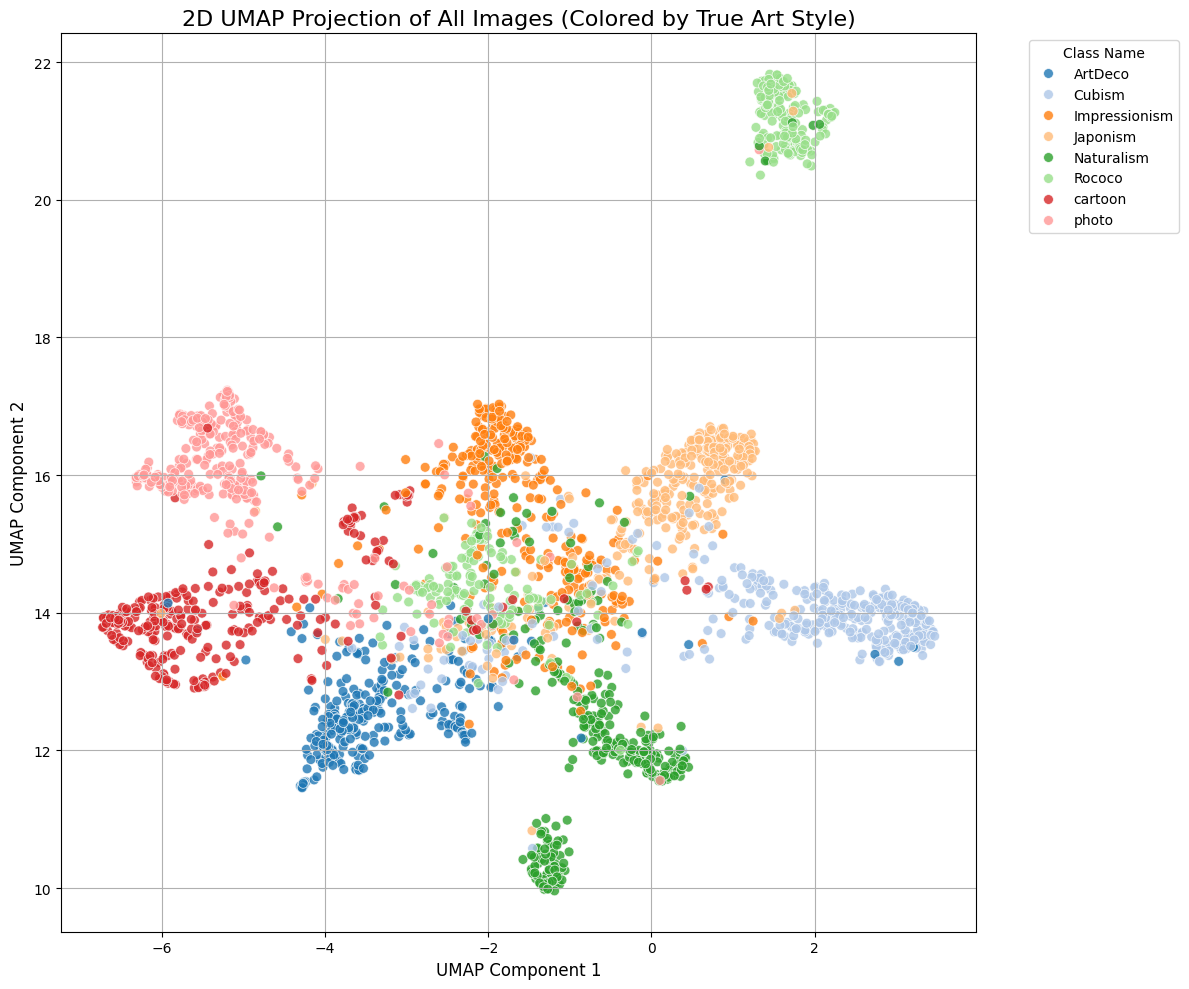

In [6]:
# Plot the 2D projection, colored by the true art style labels
plot_embeddings_2d(
    df=df, 
    x_col='umap_x', 
    y_col='umap_y', 
    hue_col='class_name', 
    title='2D UMAP Projection of All Images (Colored by True Art Style)'
)

The model clearly separates some styles into their own tight clusters, especially Rococo, which sits well above the remaining observations. Other styles are also well grouped. However, there is a noticeable mix in the center, which suggests the model finds it harder to distinguish between the styles located in that main cluster. Overall, for each art style there is a noticeable cluster in the 2D space.

Rococo likely separates best because the dataset’s Rococo images are mostly portraits, while other styles include much fewer portraits and more varied subjects. From that, it can be inferred that the vector representations mainly contain high-level semantics - things like subject matter and composition, not just “style” brushwork.

# 2. Clustering on High-Dimensional Embeddings
To assess how well the embeddings capture art-style features, I applied K-Means to the high-dimensional embeddings. K-Means splits points into K clusters by assigning each point to its nearest centroid (Euclidean) and updating centroids to minimize within-cluster variance. If the embeddings are good, samples from the same style should cluster tightly, so a centroid-based method will group them together. Ideally, each K-Means cluster maps cleanly to a single art style.

I chose 9 clusters: eight for the known classes, and one extra “catch-all” cluster to absorb the ambiguous, mixed-style images that don’t fit cleanly anywhere.

In [11]:
# Run K-Means clustering on the embeddings
print(f"Running K-Means with {NUM_CLUSTERS} clusters...")
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init='auto')
df['cluster_label'] = kmeans.fit_predict(embeddings)

Running K-Means with 9 clusters...


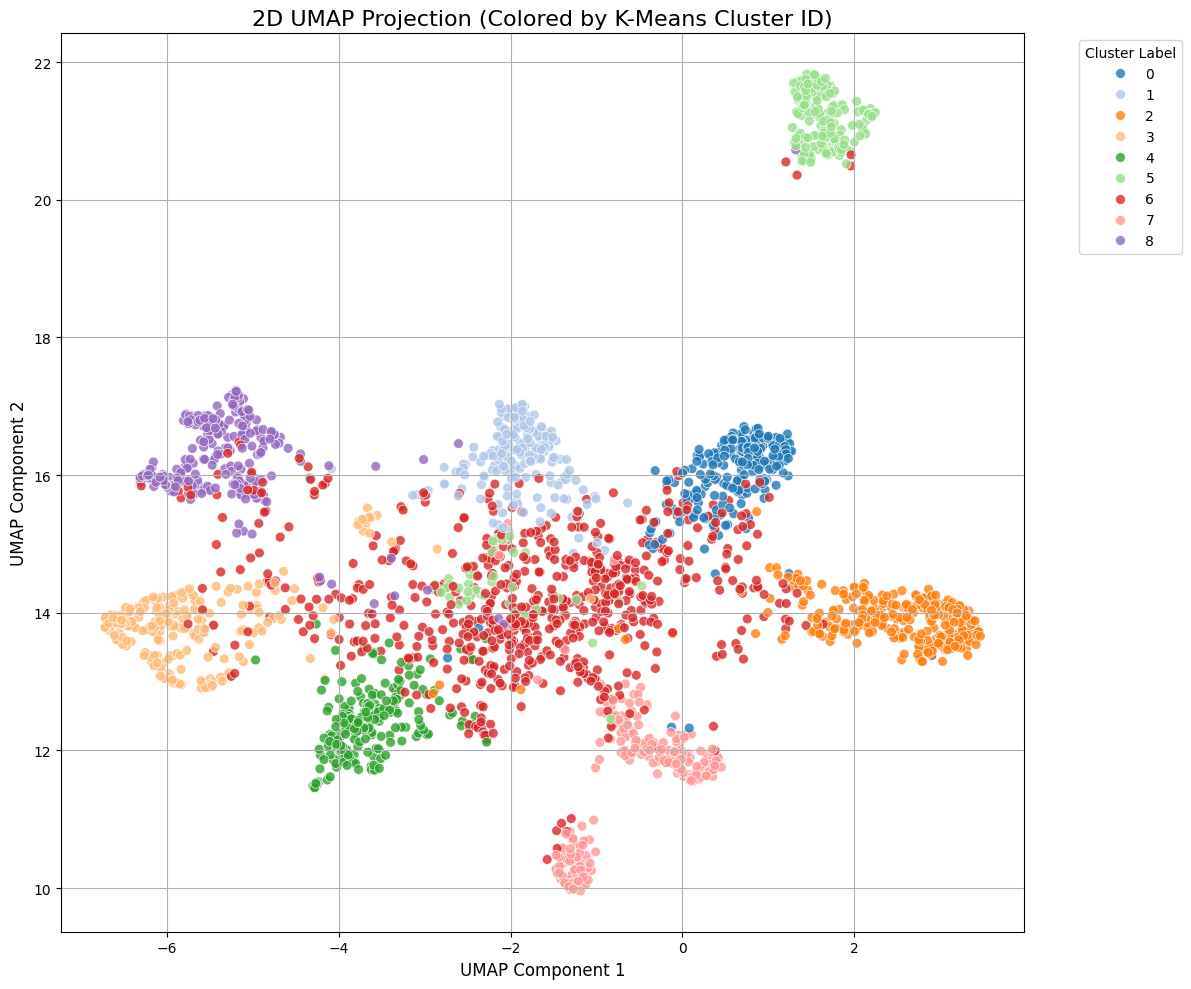

In [12]:
# Plot the 2D projection again, this time colored by the K-Means cluster labels
plot_embeddings_2d(
    df=df, 
    x_col='umap_x', 
    y_col='umap_y', 
    hue_col='cluster_label', 
    title='2D UMAP Projection (Colored by K-Means Cluster ID)'
)

In [13]:
# Analyze the relationship between true classes and predicted clusters
contingency_table = pd.crosstab(df['class_name'], df['cluster_label'])
print(contingency_table)

# Calculate the Adjusted Rand Index (ARI) to measure clustering quality
ari_score = adjusted_rand_score(df['true_label'], df['cluster_label'])
print(f"\nAdjusted Rand Index (ARI): {ari_score:.4f}")

cluster_label    0    1    2    3    4    5    6    7    8
class_name                                                
ArtDeco          1    0    3    2  218    0   78    0    0
Cubism           3    3  290    0    0    0   80    0    0
Impressionism    0  186    0    1    0    0  155    2    1
Japonism       228    3    4    1    1    3   97    0    0
Naturalism       1    9    0    0    0    8   84  247    1
Rococo           0    4    0    0    0  228   91    1    0
cartoon          0    5    0  239    2    0   60    0    1
photo            0    2    0    1    0    0   58    2  270

Adjusted Rand Index (ARI): 0.4952


## Results
Using K-Means with 9 clusters, the clusters align well with the true styles.

Clear matches:

- C0 → Japonism (228)

- C1 → Impressionism (186)

- C2 → Cubism (290)

- C3 → cartoon (239)

- C4 → ArtDeco (218)

- C5 → Rococo (228)

- C7 → Naturalism (247)

- C8 → photo (270)

C6 is the catch-all: it mixes spillover from multiple styles (e.g., Impressionism, Rococo, Japonism, Naturalism, cartoon, photo). This reflects the fuzzy, overlapping region in the embedding space. Those are the images which are harder to be classified for the model.

The UMAP view is consistent: most styles form tight islands, while the central area remains mixed and feeds C6.

Overall agreement is moderate with ARI being nearly 0.50. Good structure, but boundaries between some styles still blend.

# 3. Training of Gradient Boosting Classifier
Because the feature vectors from the fine-tuned EfficientNet-B0 separate art styles well and capture useful image cues, it’s reasonable to train a simple Gradient Boosting model for style classification.

**Note:** For this section, the validation set isn’t needed. I merge the train and validation splits to increase the training data.

In [ ]:
# 1. Extract embeddings for train, validation, and test sets
print("Extracting embeddings for train, val, and test sets...")
X_train, y_train = get_all_embeddings(model, train_loader, DEVICE)
X_val, y_val = get_all_embeddings(model, val_loader, DEVICE)
X_test, y_test = get_all_embeddings(model, test_loader, DEVICE)

# 2. Combine training and validation sets for a larger training pool
print("\nCombining train and validation embeddings for training...")
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)
print(f"Combined training embeddings shape: {X_train_val.shape}")
print(f"Test embeddings shape: {X_test.shape}")

Extracting embeddings for train, val, and test sets...

Combining train and validation embeddings for training...
Combined training embeddings shape: (2460, 1280)
Test embeddings shape: (214, 1280)


To optimize training, I use random search for hyperparameter tuning to find strong settings. I then evaluate the final model on the test set.

In [ ]:
# Define the base Gradient Boosting model
gb = GradientBoostingClassifier(random_state=618)

# Specify the hyperparameter search space
param_dist = {
    "n_estimators": randint(100, 600),
    "learning_rate": loguniform(1e-3, 3e-1),
    "max_depth": randint(1, 5),
}

# Set up stratified cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=618)

# Configure randomized hyperparameter search
search = RandomizedSearchCV(
    gb,
    param_distributions=param_dist,
    n_iter=25,
    scoring="f1_macro",
    n_jobs=-1,
    cv=cv,
    random_state=618,
)

# Run hyperparameter search on train+val embeddings
search.fit(X_train_val, y_train_val)

# Report best settings and CV performance
print("Best params:", search.best_params_)
print("CV best score (mean):", search.best_score_)

# Retrieve the best-fitted model
best = search.best_estimator_

# Predict on the test set
y_pred_gb = best.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_gb)
print(f"Test acc: {test_acc:.4f}")

Best params: {'learning_rate': 0.12696206363808887, 'max_depth': 3, 'n_estimators': 334}
CV best score (mean): 0.8824393052043163
Test acc: 0.7897


In [ ]:
print(classification_report(y_test, y_pred_gb, target_names=train_ds.classes))

               precision    recall  f1-score   support

      ArtDeco       0.71      0.50      0.59        10
       Cubism       0.87      0.82      0.84        55
Impressionism       0.72      0.72      0.72        36
     Japonism       0.83      0.83      0.83        30
   Naturalism       0.80      0.85      0.82        33
       Rococo       0.64      0.89      0.74        18
      cartoon       0.62      0.45      0.53        11
        photo       0.90      0.90      0.90        21

     accuracy                           0.79       214
    macro avg       0.76      0.75      0.75       214
 weighted avg       0.79      0.79      0.79       214



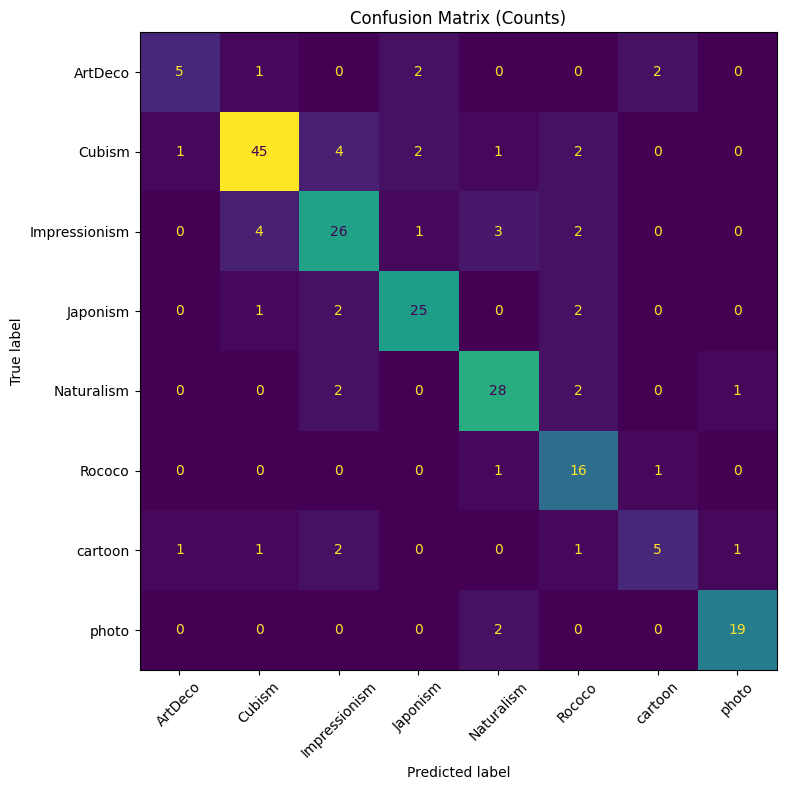

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_gb, test_ds.classes)

## Results
The results are similar to those from the EfficientNet-B0 classifier in §2.2. This model also performs worst on the underrepresented classes.

It’s interesting because in 2D space, ArtDeco and cartoon looked well separated. However, a few points sat in the messy region of the plot—likely the test samples—which caused errors.

The main issue with underrepresented classes is overfitting to augmented images. A better fix is to add more diverse real images from those classes for better performance.